In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import re
import string
from collections import  Counter
from wordcloud import WordCloud , STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix, precision_score, recall_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import LSTM, Embedding, Dense, BatchNormalization, Dropout, Bidirectional, Input, GRU
from keras.models import Sequential
from keras import Model
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, DistilBertModel, DistilBertTokenizer

In [4]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train_df[train_df['target']==0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


# Data Exploration

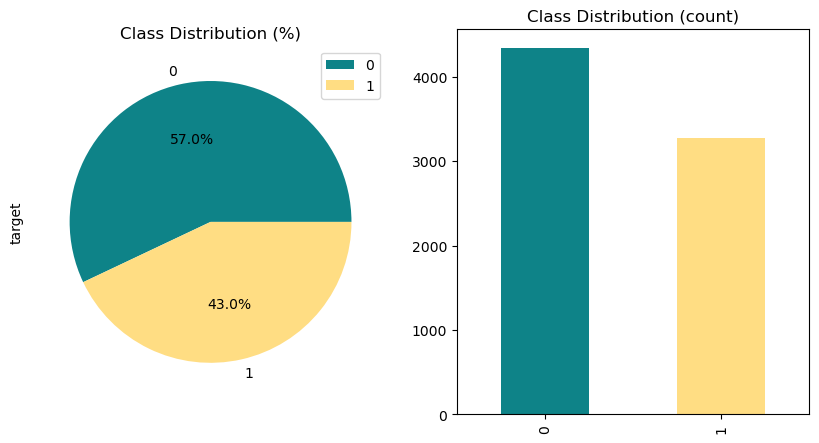

In [10]:
x=train_df.target.value_counts()
df = x

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot axpie chart
df.plot(kind='pie', ax=ax1, autopct='%1.1f%%', colors=['#0E8388','#FFDD83'])
ax1.legend(loc="best")
ax1.set_title('Class Distribution (%)')

# Plot a bar chart

df.plot(kind='bar', x='B', y='A', ax=ax2, color=['#0E8388','#FFDD83'])
ax2.set_title('Class Distribution (count)')

# Show the plot
plt.show()

Average number of words in disaster tweets: 15.167532864567411
Average number of words in disaster tweets: 14.704744357438969


Text(0.5, 0.98, 'Words in a tweet')

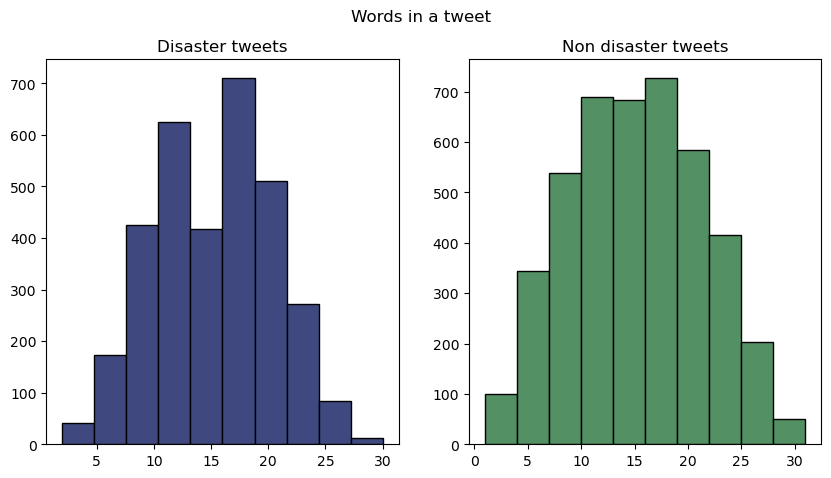

In [11]:
#Number of words in a tweet
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = train_df[train_df['target']==1]['text'].str.split().map(lambda x: len(x))
print("Average number of words in disaster tweets:",np.mean(tweet_len))
ax1.hist(tweet_len, color='#3F497F', edgecolor='black')
ax1.set_title('Disaster tweets')
tweet_len = train_df[train_df['target']==0]['text'].str.split().map(lambda x: len(x))
print("Average number of words in disaster tweets:",np.mean(tweet_len))
ax2.hist(tweet_len,color='#539165', edgecolor='black')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')

In [12]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [14]:
#Disaster Tweets Vocab
disaster_tweets = train_df[train_df['target']==1]['text']
disaster_words = []
for tweet in disaster_tweets:
    tweet = tweet.lower()
    words = tweet.split()
    for word in words:
        disaster_words.append(word)
    

disaster_vocab = list(set(disaster_words))
print("Vocab length before removing punctuations: ",len(disaster_vocab))

disaster_words = []
for tweet in disaster_tweets:
    tweet = remove_URL(tweet)
    tweet = clean_text(tweet)
    words = tweet.split()
    for word in words:
        disaster_words.append(word)
    
newVocab = list(set(disaster_words))
print("Vocab length after cleaning: ",len(newVocab))
disaster_vocab = newVocab

Vocab length before removing punctuations:  14302
Vocab length after cleaning:  8852


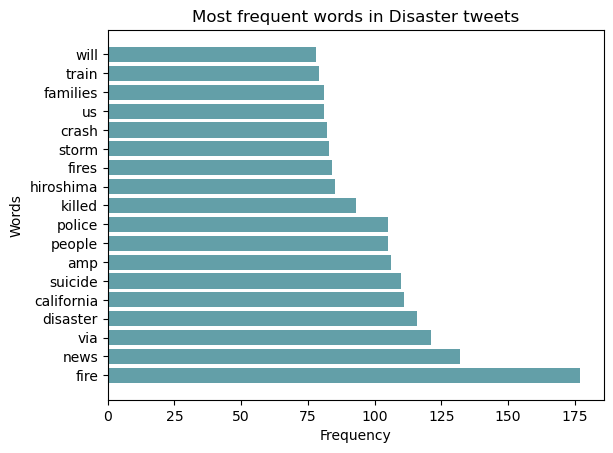

In [15]:
#Common words in disaster tweets
counter = Counter(disaster_words)
top_words = counter.most_common()

word_labels = []
word_freqs = []

for word, count in top_words[:60]:
    if word not in STOPWORDS:
        word_labels.append(word)
        word_freqs.append(count)

plt.barh(word_labels, word_freqs, color='#639FA8')
plt.title("Most frequent words in Disaster tweets")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [16]:
#Non Disaster Tweets Vocab
non_disaster_tweets = train_df[train_df['target']==0]['text']
non_disaster_words = []
for tweet in non_disaster_tweets:
    tweet = tweet.lower()
    words = tweet.split()
    for word in words:
        non_disaster_words.append(word)

non_disaster_vocab = list(set(non_disaster_words))
print("Vocab length before removing punctuations: ",len(non_disaster_vocab))

non_disaster_words = []
for tweet in non_disaster_tweets:
    tweet = remove_URL(tweet)
    tweet = clean_text(tweet)
    words = tweet.split()
    for word in words:
        non_disaster_words.append(word)
    
newVocab = list(set(non_disaster_words))
print("Vocab length after removing punctuations: ",len(newVocab))
non_disaster_vocab = newVocab

Vocab length before removing punctuations:  17968
Vocab length after removing punctuations:  11910


[('the', 1896), ('a', 1249), ('to', 1186), ('i', 1071), ('and', 912)]


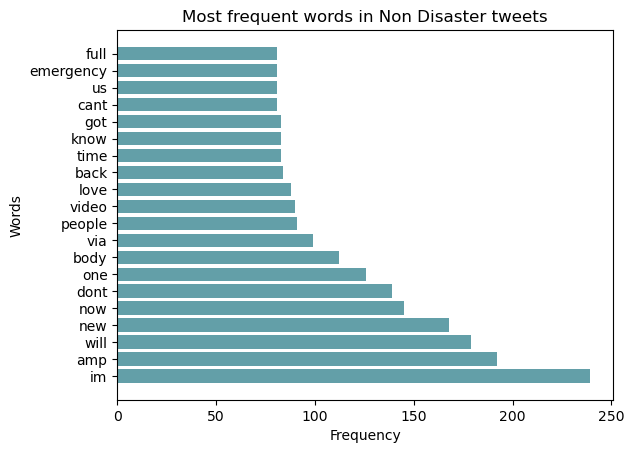

In [17]:
#Common words in non disaster tweets
counter = Counter(non_disaster_words)
top_words = counter.most_common()
print(top_words[:5])

word_labels = []
word_freqs = []

for word, count in top_words[:80]:
    if word not in STOPWORDS:
        word_labels.append(word)
        word_freqs.append(count)

plt.barh(word_labels, word_freqs, color='#639FA8')
plt.title("Most frequent words in Non Disaster tweets")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [18]:
#Word clouds
cloud1 = WordCloud(stopwords =STOPWORDS, background_color='white',min_word_length=2,random_state= 53).generate(str(' '.join(disaster_words)))
cloud2 = WordCloud(stopwords =STOPWORDS, background_color='white',min_word_length=2,random_state= 53).generate(str(' '.join(non_disaster_words)))

Text(0.5, 1.0, 'Non disaster Tweets')

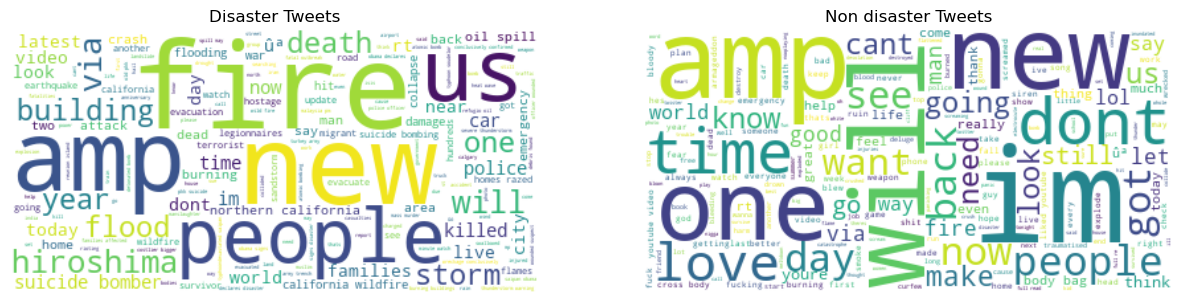

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.imshow(cloud1, interpolation = 'bilinear')
ax1.axis('off')
ax1.set_title("Disaster Tweets")

ax2.imshow(cloud2, interpolation = 'bilinear')
ax2.axis('off')
ax2.set_title("Non disaster Tweets")

In [20]:
for key in cloud1.words_.keys():
    if cloud2.words_.get(key,False):
        if cloud2.words_.get(key,None)> 0.3 and cloud1.words_.get(key,None) > 0.3:
            print(f'{key:10} {round(cloud1.words_[key],2):10}{round(cloud2.words_[key],2):10}')

new              0.85      0.57
amp              0.67      0.69
us               0.51      0.31
people           0.49       0.4
will             0.47      0.59
one              0.42      0.51
now              0.35      0.36
im               0.35       1.0
time             0.34      0.41


# Data Preprocessing

In [21]:
# Applying the cleaning function to both test and training datasets
train_df['text'] = train_df['text'].apply(lambda x: clean_text(remove_URL(x)))
train_df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [22]:
test_df['text'] = test_df['text'].apply(lambda x: clean_text(remove_URL(x)))
test_df['text'].head()

0                   just happened a terrible car crash
1    heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3                apocalypse lighting spokane wildfires
4          typhoon soudelor kills  in china and taiwan
Name: text, dtype: object

In [23]:
#Bigram analysis after data preprocessing
def get_top_tweet_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if word]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Text(0.5, 0, 'Frequency')

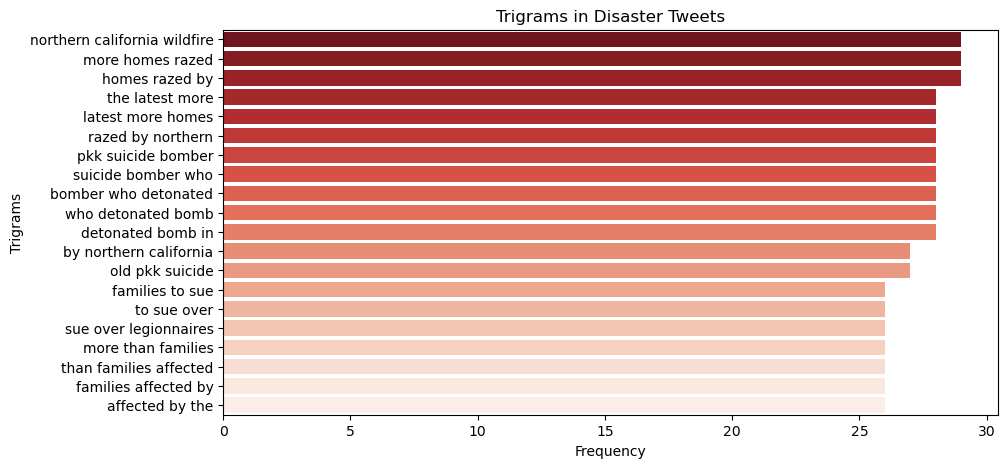

In [24]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_ngrams(train_df[train_df['target']==1]['text'])[:20]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, palette='Reds_r')
plt.title("Trigrams in Disaster Tweets")
plt.ylabel('Trigrams')
plt.xlabel('Frequency')

Text(0.5, 0, 'Frequency')

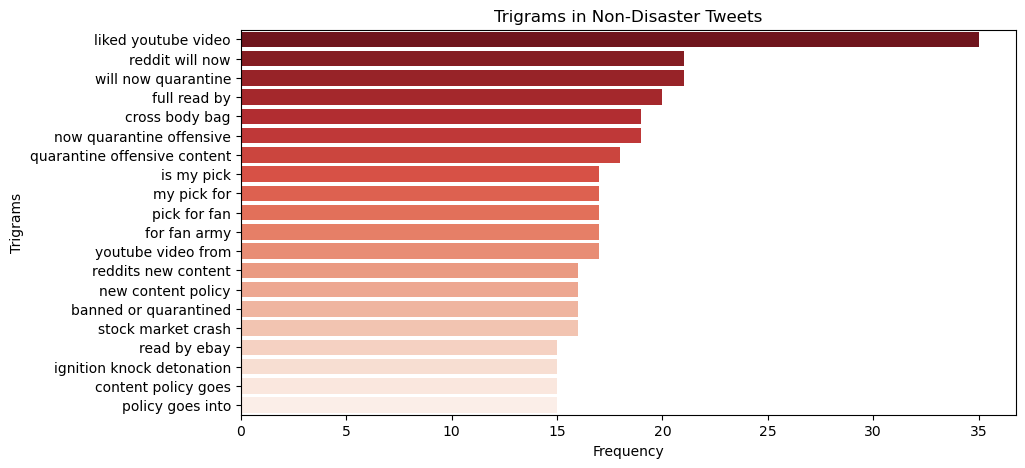

In [25]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_ngrams(train_df[train_df['target']==0]['text'])[:20]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, palette='Reds_r')
plt.title("Trigrams in Non-Disaster Tweets")
plt.ylabel('Trigrams')
plt.xlabel('Frequency')

# **Model Exploration**

In [63]:
X = train_df['text']
y = train_df['target']

In [43]:
def remove_stopwords(text):
    words = text.split()
    
    filtered_words = [word for word in words if word not in STOPWORDS]
    filtered_sentence = " ".join(filtered_words)
    return filtered_sentence

In [64]:
classifier = TfidfVectorizer()
X = classifier.fit_transform(X)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [66]:
#SVM Classifier
model=SVC(kernel = 'linear', C=1)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

accuracy_score(y_test,y_pred)

0.8019957983193278

In [67]:
f1_score(y_test,y_pred)

0.7491683300066533

In [68]:
precision_score(y_test,y_pred)

0.8608562691131498

In [69]:
recall_score(y_test,y_pred)

0.6631330977620731

In [51]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    #'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}


svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best hyperparameters: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
test_acc = best_model.score(X_test, y_test)
print("Test accuracy with best hyperparameters: ", test_acc)


Best hyperparameters:  {'C': 1, 'kernel': 'linear'}
Test accuracy with best hyperparameters:  0.7951680672268907


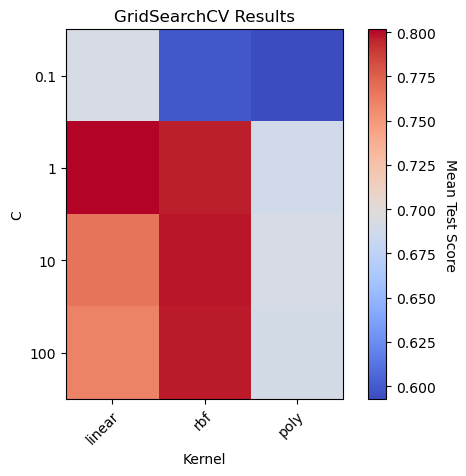

In [52]:
# Get the mean test scores for each combination of hyperparameters
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Reshape the mean test scores to a 2D array
mean_test_scores = mean_test_scores.reshape(4, 3)

# Plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(mean_test_scores, cmap='coolwarm')

# Set the tick labels
ax.set_xticks(np.arange(len(param_grid['kernel'])))
ax.set_yticks(np.arange(len(param_grid['C'])))
ax.set_xticklabels(param_grid['kernel'])
ax.set_yticklabels(param_grid['C'])

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Add the colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the axis labels
ax.set_xlabel('Kernel')
ax.set_ylabel('C')
cbar.ax.set_ylabel('Mean Test Score', rotation=270, labelpad=15)

# Set the title
ax.set_title('GridSearchCV Results')

# Show the plot
plt.show()


In [70]:
#Random Forest Classifier
num_trees = [ 10, 20, 40, 80, 100, 120, 150]
entropy_accuracies = []
gini_accuracies = []
for num in num_trees:
    print("Training random forest with " + str(num) + " trees.")
    model=RandomForestClassifier(n_estimators = num, criterion='entropy')
    model.fit(X_train,y_train)
    
    y_pred=model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    print("Accuracy: ", accuracy)
    print("------------------------------")
    entropy_accuracies.append(accuracy)
    
    print("Training random forest with " + str(num) + " trees.")
    model=RandomForestClassifier(n_estimators = num, criterion='gini')
    model.fit(X_train,y_train)
    
    y_pred=model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    print("Accuracy: ", accuracy)
    print("------------------------------")
    gini_accuracies.append(accuracy)

Training random forest with 10 trees.
Accuracy:  0.7615546218487395
------------------------------
Training random forest with 10 trees.
Accuracy:  0.7468487394957983
------------------------------
Training random forest with 20 trees.
Accuracy:  0.7736344537815126
------------------------------
Training random forest with 20 trees.
Accuracy:  0.7657563025210085
------------------------------
Training random forest with 40 trees.
Accuracy:  0.7715336134453782
------------------------------
Training random forest with 40 trees.
Accuracy:  0.7725840336134454
------------------------------
Training random forest with 80 trees.
Accuracy:  0.7767857142857143
------------------------------
Training random forest with 80 trees.
Accuracy:  0.7883403361344538
------------------------------
Training random forest with 100 trees.
Accuracy:  0.7773109243697479
------------------------------
Training random forest with 100 trees.
Accuracy:  0.779936974789916
------------------------------
Training 

In [71]:
from sklearn.metrics import precision_score, recall_score

# Assuming you have already trained your random forest model
y_pred = model.predict(X_test) # X_test is the test data
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Precision: ", precision)
print("Recall: ", recall)


Precision:  0.8685121107266436
Recall:  0.591283863368669


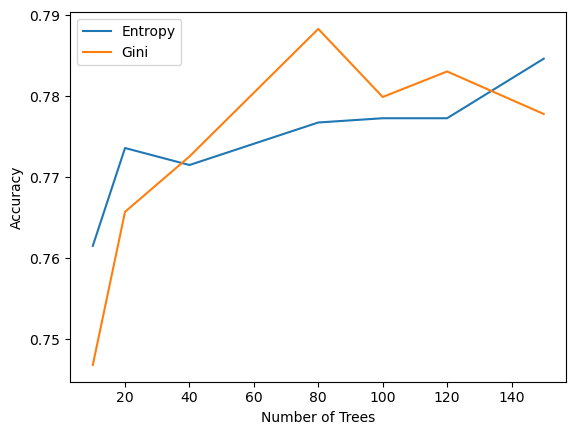

In [72]:
plt.plot(num_trees, entropy_accuracies, label='Entropy')
plt.plot(num_trees, gini_accuracies, label='Gini')
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
# plt.title('Two lines on the same graph')

plt.legend()
plt.show()

In [73]:
depths = [60,80,100,120]
accuracies = []
for depth in depths:
    print("Training random forest with " + str(depth) + " depth.")
    model=RandomForestClassifier(n_estimators = 100, max_depth = depth)
    model.fit(X_train,y_train)
    
    y_pred=model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    print("Accuracy: ", accuracy)
    print("------------------------------")
    accuracies.append(accuracy)
    

Training random forest with 60 depth.
Accuracy:  0.7484243697478992
------------------------------
Training random forest with 80 depth.
Accuracy:  0.7652310924369747
------------------------------
Training random forest with 100 depth.
Accuracy:  0.7720588235294118
------------------------------
Training random forest with 120 depth.
Accuracy:  0.7678571428571429
------------------------------


In [74]:
model=RandomForestClassifier(n_estimators = 120,  criterion='gini')
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

accuracy_score(y_test,y_pred)

0.7904411764705882

In [75]:
print("F1 score:",f1_score(y_test,y_pred))
print("Precision score:",precision_score(y_test,y_pred))
print("Recall score:",recall_score(y_test,y_pred))

F1 score: 0.7227241139680334
Precision score: 0.8813559322033898
Recall score: 0.6124852767962309


In [27]:
#GloVe Word Vectors and LSTM Model
X = train_df['text']
y = train_df['target']

In [28]:
print(X.shape)
print(y.shape)

(7613,)
(7613,)


In [29]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
vocab_length = len(word_tokenizer.word_index) + 1
print(vocab_length)

16834


In [30]:
sequences = word_tokenizer.texts_to_sequences(X)
max_length = max(len(sequence) for sequence in sequences)
padded_sentences = pad_sequences(sequences, max_length, padding='post')
padded_sentences[0]

array([ 107, 4290,   20,    1,  834,    5,   18,  231,  123, 1629, 4291,
         68,   39,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [31]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('../input/glove-file/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [32]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [33]:
X_train, X_test, y_train, y_test = train_test_split(padded_sentences, y, test_size=0.25)

In [34]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epoch',fontsize=16)
        ax[idx].set_ylabel(arr[idx][2],fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [72]:
 def Glove_LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=max_length))
    model.add(Bidirectional(LSTM(128, return_sequences = True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(32, return_sequences = True)))
    model.add(Dropout(0.5))
    model.add(Dense(max_length, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [73]:
model = Glove_LSTM_Model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 31, 100)           1683400   
                                                                 
 bidirectional_18 (Bidirecti  (None, 31, 256)          234496    
 onal)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 31, 256)           0         
                                                                 
 bidirectional_19 (Bidirecti  (None, 31, 64)           73984     
 onal)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 31, 64)            0         
                                                                 
 dense_18 (Dense)            (None, 31, 31)           

In [74]:
history = model.fit(X_train, y_train, epochs=8, batch_size = 32, validation_data = [X_test, y_test], verbose = 1)

Epoch 1/8
179/179 [==============================] - 22s 91ms/step - loss: 0.5144 - accuracy: 0.7673 - val_loss: 0.4435 - val_accuracy: 0.7969
Epoch 2/8
179/179 [==============================] - 15s 83ms/step - loss: 0.4492 - accuracy: 0.8152 - val_loss: 0.4507 - val_accuracy: 0.8012
Epoch 3/8
179/179 [==============================] - 15s 83ms/step - loss: 0.4201 - accuracy: 0.8318 - val_loss: 0.4375 - val_accuracy: 0.8072
Epoch 4/8
179/179 [==============================] - 15s 84ms/step - loss: 0.3976 - accuracy: 0.8438 - val_loss: 0.4437 - val_accuracy: 0.8082
Epoch 5/8
179/179 [==============================] - 15s 83ms/step - loss: 0.3671 - accuracy: 0.8567 - val_loss: 0.4794 - val_accuracy: 0.8169
Epoch 6/8
179/179 [==============================] - 15s 84ms/step - loss: 0.3456 - accuracy: 0.8655 - val_loss: 0.4427 - val_accuracy: 0.8061
Epoch 7/8
179/179 [==============================] - 15s 85ms/step - loss: 0.3145 - accuracy: 0.8786 - val_loss: 0.4680 - val_accuracy: 0.8143

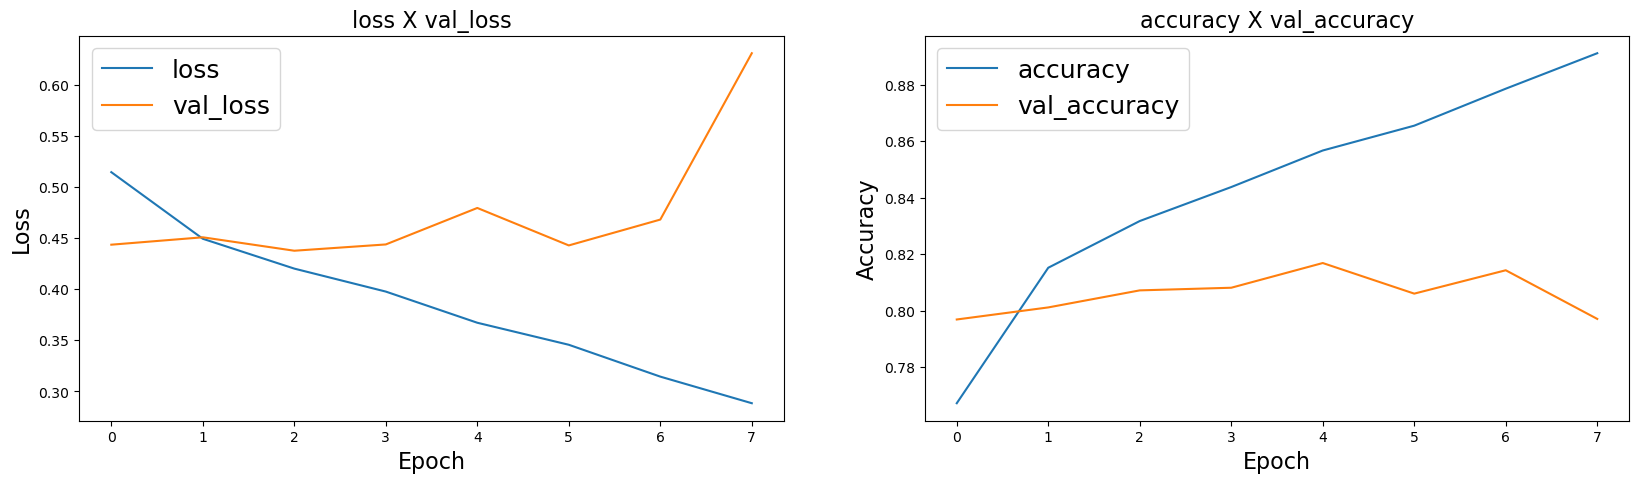

In [75]:
plot(history, [['loss', 'val_loss', 'Loss'],['accuracy', 'val_accuracy', 'Accuracy']])